In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Генерация синтетического датасета продаж с сезонностью (имитация реальных данных)
np.random.seed(42)
date_rng = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
sales = 100 + 0.05 * np.arange(len(date_rng)) + \
        20 * np.sin(2 * np.pi * np.arange(len(date_rng)) / 365.25) + \
        10 * np.sin(2 * np.pi * np.arange(len(date_rng)) / 7) + \
        np.random.normal(0, 5, len(date_rng))

df = pd.DataFrame({
    'ds': date_rng,
    'y': np.maximum(sales, 0)  # Продажи не могут быть отрицательными
})

print("Первые 5 строк сгенерированного датасета:")
print(df.head())

Importing plotly failed. Interactive plots will not work.


Первые 5 строк сгенерированного датасета:
          ds           y
0 2020-01-01  102.483571
1 2020-01-02  107.521025
2 2020-01-03  113.775683
3 2020-01-04  113.135674
4 2020-01-05   96.065504


In [2]:
# Разделим данные: обучение на данных до 2023 года, тест на 2023 год
train = df[df['ds'] < '2023-01-01']
test = df[df['ds'] >= '2023-01-01']

print(f"\nРазмер обучающей выборки: {len(train)}")
print(f"Размер тестовой выборки: {len(test)}")


Размер обучающей выборки: 1096
Размер тестовой выборки: 365


In [3]:
# Создание и обучение модели
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.95
)

model.fit(train)

# Создание будущего датафрейма для прогноза
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Извлечение прогноза для тестового периода
forecast_test = forecast[forecast['ds'] >= '2023-01-01'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

19:58:39 - cmdstanpy - INFO - Chain [1] start processing
19:58:39 - cmdstanpy - INFO - Chain [1] done processing



--- Результаты прогнозирования ---
Средняя абсолютная ошибка (MAE): 4.12
Среднеквадратичная ошибка (RMSE): 5.17


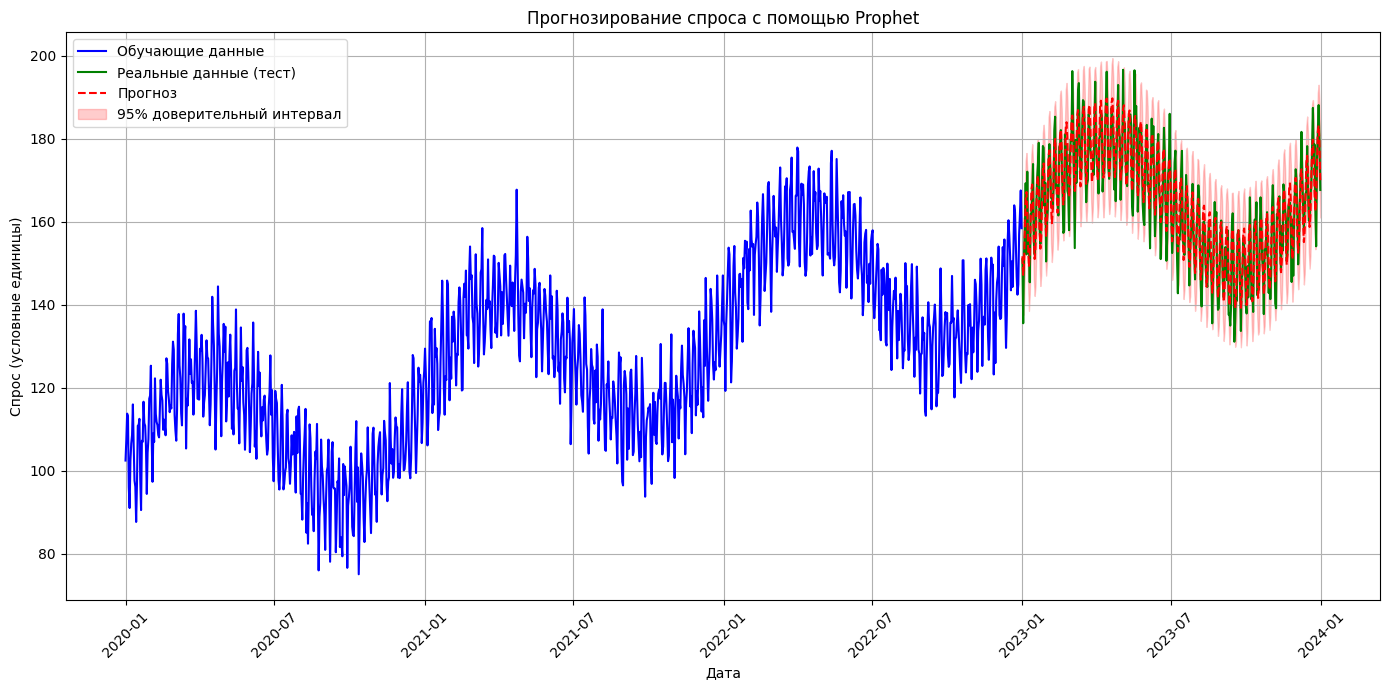

In [4]:
# Объединение реальных и прогнозируемых значений
results = test.copy()
results['yhat'] = forecast_test['yhat'].values

# Расчет метрик
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

print(f"\n--- Результаты прогнозирования ---")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (RMSE): {rmse:.2f}")

# Визуализация
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(train['ds'], train['y'], label='Обучающие данные', color='blue')
ax.plot(test['ds'], test['y'], label='Реальные данные (тест)', color='green')
ax.plot(test['ds'], results['yhat'], label='Прогноз', color='red', linestyle='--')
ax.fill_between(test['ds'],
                forecast_test['yhat_lower'],
                forecast_test['yhat_upper'],
                color='red', alpha=0.2, label='95% доверительный интервал')

ax.set_title('Прогнозирование спроса с помощью Prophet')
ax.set_xlabel('Дата')
ax.set_ylabel('Спрос (условные единицы)')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()